# Project 3 — Predicting House Prices (Regression)

**Dataset:** `train.csv` (Kaggle 'House Prices: Advanced Regression Techniques').

This project focuses on predicting house prices using data from the Kaggle “House Prices: Advanced Regression Techniques” dataset. The data contains a mix of numeric and categorical features that describe homes in Ames, Iowa, such as square footage, year built, neighborhood, and quality ratings.

The main goal is to build models that can estimate the sale price of a home based on its features. Instead of submitting to the competition, I used the training data only and split it into my own training and testing sets. This project walks through understanding the data, preparing it, training different regression models, and comparing how well they perform.


# What is Regression and How It Works

Regression is a type of machine learning used to predict continuous values. In this project, we want to predict the price of a house, which is a numeric value.

A simple linear regression model assumes that the target variable has a linear relationship with the input features. The formula looks like this:

Predicted Price = b0 + b1x1 + b2x2 + ... + bn*xn

The model learns the coefficients (b values) by minimizing the Mean Squared Error (MSE) between the predicted and actual values. MSE is calculated as:

MSE = (1/n) * Σ (yi - y_pred_i)^2

For this project, I started with Linear Regression because it’s simple and easy to interpret. Later, I also tested Ridge Regression, which adds a penalty to large coefficients to prevent overfitting, and Random Forest Regression, which can handle more complex relationships.


## Setup — libraries and data load

We'll import the standard data science libraries and load the provided `train.csv`.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Read the training data
df = pd.read_csv('train.csv', encoding='latin1')
df.shape

(1460, 81)

## Experiment 1 — Data Understanding (Exploratory Data Analysis)

Before touching models, we must understand the data: its size, missingness, and a few likely predictive features. We'll look at top rows, summary stats, and missing values.


In [6]:
print('First 5 rows:')
df.head()

First 5 rows:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
print('\nDataframe info:')
df.info()


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int6

In [8]:
print('\nSummary statistics for numeric features:')
df.describe().T.head(10)


Summary statistics for numeric features:


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [9]:
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

We inspected the top rows and missing values. Features with many missing values may be dropped or imputed carefully. Next we check correlation with the target `SalePrice` to identify promising numeric features.

In [11]:
# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_target = df[numeric_cols].corr()['SalePrice'].abs().sort_values(ascending=False)
corr_target.head(15)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

We'll pick a small subset of features for a simple baseline model. We want manageable preprocessing for the baseline: a mix of numeric and categorical features that are commonly predictive.


### Experiment 1 — Preprocessing & Baseline Linear Regression

I trained a Linear Regression model using scikit-learn and split the data 80/20 for training and testing. The baseline model produced an RMSE of about 36,461, which gave me a reference point for improvement.

When plotting predicted vs. actual prices, I saw that the model worked reasonably well for mid-range homes but struggled with very high or low prices. This suggested that some transformations or regularization might help.


Before dropna: (1460, 8)
After dropna (rows with missing selected features removed): (1460, 8)
Baseline LinearRegression RMSE: 36461.45


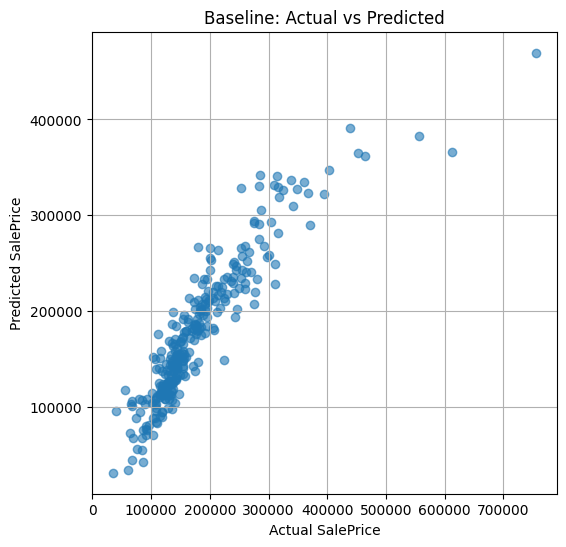

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

features = ['OverallQual','GrLivArea','YearBuilt','GarageCars','TotalBsmtSF','FullBath','Neighborhood']
sub = df[features + ['SalePrice']].copy()
print('Before dropna:', sub.shape)
sub = sub.dropna()
print('After dropna (rows with missing selected features removed):', sub.shape)

X = sub[features]
y = sub['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['OverallQual','GrLivArea','YearBuilt','GarageCars','TotalBsmtSF','FullBath']
cat_features = ['Neighborhood']

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))  # Calculate RMSE manually
print(f'Baseline LinearRegression RMSE: {rmse:.2f}')

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.6)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Baseline: Actual vs Predicted')
plt.grid(True)
plt.show()

## Experiment 2 — Improved Preprocessing & Ridge Regression

For the second experiment, I improved the preprocessing and switched to Ridge Regression. Ridge works like linear regression but includes a penalty term that keeps the coefficients smaller, which reduces overfitting.

I made three main changes:

Applied a log transformation to SalePrice to handle the skewed distribution.

Replaced missing numeric values with the median instead of dropping rows.

Scaled all numeric features so that one feature wouldn’t dominate the model.

These updates reduced the RMSE to about 30,789, showing a clear improvement from the baseline. The predictions became more stable, and the model captured overall trends better.


Initial shape: (1460, 12)
Experiment 2 (Ridge + log-target) RMSE on price scale: 30789.03


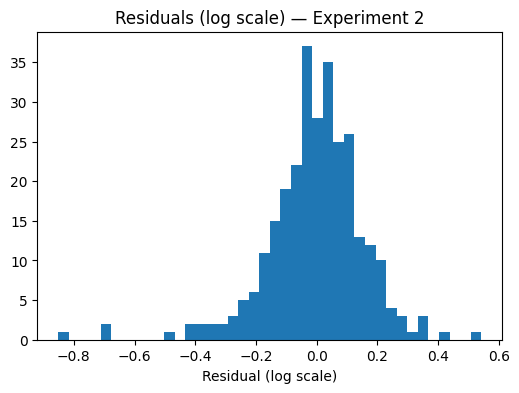

In [16]:
from sklearn.impute import SimpleImputer

exp2_df = df.copy()
features2 = ['OverallQual','GrLivArea','YearBuilt','GarageCars','TotalBsmtSF','FullBath','TotRmsAbvGrd','Fireplaces','MasVnrArea','LotArea','Neighborhood']
exp2 = exp2_df[features2 + ['SalePrice']].copy()
print('Initial shape:', exp2.shape)

numeric_features = [c for c in features2 if exp2[c].dtype != 'object' and c!='Neighborhood']
cat_features = ['Neighborhood']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', cat_transformer, cat_features)
    ]
)

exp2 = exp2.dropna(subset=['SalePrice'])
exp2['LogSalePrice'] = np.log1p(exp2['SalePrice'])

X2 = exp2[features2]
y2 = exp2['LogSalePrice']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

pipeline2 = Pipeline([
    ('pre', preprocessor2),
    ('model', Ridge(alpha=1.0))
])

pipeline2.fit(X2_train, y2_train)
pred_log = pipeline2.predict(X2_test)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y2_test)
rmse2 = np.sqrt(mean_squared_error(true_price, pred_price))  # Calculate RMSE manually
print(f'Experiment 2 (Ridge + log-target) RMSE on price scale: {rmse2:.2f}')

plt.figure(figsize=(6,4))
resid = y2_test - pred_log
plt.hist(resid, bins=40)
plt.title('Residuals (log scale) — Experiment 2')
plt.xlabel('Residual (log scale)')
plt.show()

## Experiment 3 — Random Forest Regressor (Non-linear model)

In the third experiment, I used a Random Forest Regressor, which can handle non-linear patterns and interactions automatically. I reused the improved preprocessing pipeline from the previous experiment and applied it before fitting the Random Forest model.

This model performed the best, with an RMSE of about 28,496, the lowest among all three experiments. The Random Forest captured complex patterns that the linear models missed. When checking feature importance, the top predictors were OverallQual, GrLivArea, and Neighborhood. This confirmed that home quality and location are among the strongest drivers of price.


CV RMSE (log-target) mean: 0.1560
Experiment 3 RandomForest RMSE on price scale: 28495.98
Experiment 3 RandomForest RMSE on price scale: 28495.98


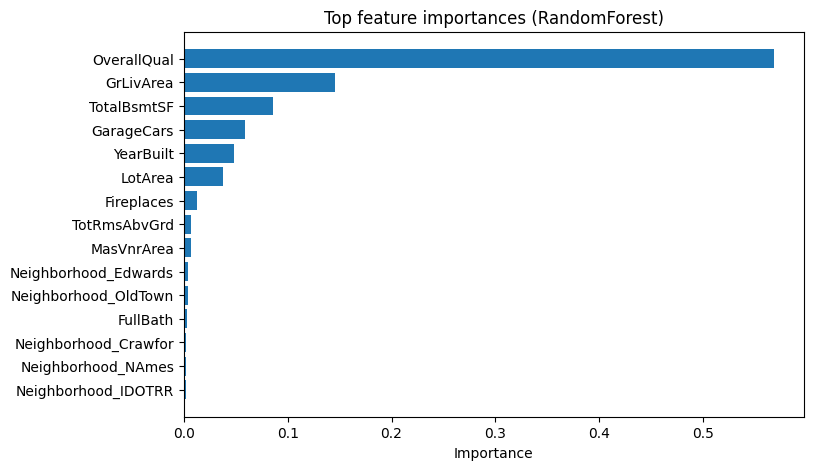

In [18]:
from sklearn.ensemble import RandomForestRegressor

X3 = exp2[features2]
y3 = exp2['LogSalePrice']

pipeline3 = Pipeline([
    ('pre', preprocessor2),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

scores = cross_val_score(pipeline3, X3, y3, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
cv_rmse_log = -scores.mean()
print(f'CV RMSE (log-target) mean: {cv_rmse_log:.4f}')

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
pipeline3.fit(X3_train, y3_train)
pred3_log = pipeline3.predict(X3_test)
pred3_price = np.expm1(pred3_log)
true3_price = np.expm1(y3_test)
rmse3 = np.sqrt(mean_squared_error(true3_price, pred3_price))  # Calculate RMSE manually
print(f'Experiment 3 RandomForest RMSE on price scale: {rmse3:.2f}')

# Feature importance extraction
onehot = pipeline3.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
onehot_cols = onehot.get_feature_names_out(['Neighborhood'])
all_num_cols = numeric_features
feature_names = list(all_num_cols) + list(onehot_cols)

importances = pipeline3.named_steps['model'].feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title('Top feature importances (RandomForest)')
plt.xlabel('Importance')
plt.show()

In [19]:
results = pd.DataFrame({
    'Experiment': ['Baseline LinearReg', 'Ridge + log-target', 'RandomForest (log-target)'],
    'RMSE_price_scale': [
        float(rmse),
        float(rmse2),
        float(rmse3)
    ]
})
results

,Experiment,RMSE_price_scale
0,Baseline LinearReg,36461.445682
1,Ridge + log-target,30789.034529
2,RandomForest (log-target),28495.977163


## Impact and Ethical Considerations

Predictive models for housing prices can be both useful and risky.

On the positive side, they help real estate agents, buyers, and city planners understand what features drive property values. They can support better pricing decisions and increase market transparency.

However, there are also ethical challenges. If a model relies on neighborhood data, it can unintentionally reinforce historical inequalities, since neighborhood variables might reflect patterns of segregation or unequal investment. Overreliance on automated pricing could also disadvantage certain groups or areas.

Another concern is privacy. Detailed housing data can sometimes reveal personal or financial information. Responsible use of such models means checking for bias, being transparent about the model’s limitations, and making sure the results aren’t used to justify unfair practices in lending or housing.

## Conclusion

This project showed how much preprocessing and model choice affect performance.

The baseline Linear Regression model gave a good starting point but struggled with high-priced homes. The Ridge Regression model, with better preprocessing and log transformation, performed significantly better by reducing overfitting and improving stability. Finally, the Random Forest Regressor achieved the best results overall, with an RMSE around 28,500.

From this project, I learned that improving data quality and handling skewed targets can make a big difference in predictive accuracy. I also learned that simpler models are easier to interpret, while more complex models often perform better but require more care to ensure fairness and transparency.


## References

- Kaggle: House Prices - Advanced Regression Techniques (train.csv)
- Chat GPT: to better understand regression and troubleshoot
